Assignment 2 - Train Ticket Predictions
Author - Ananth Vikram

In [234]:
#Load required libraries

import numpy as np # linear algebra
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
import os
import seaborn as sns
import matplotlib.pyplot as plt
from  sklearn.metrics import confusion_matrix 
import logging,sys
from sklearn import preprocessing, neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import re
from datetime import date
import calendar

In [235]:
#Input data file

ticket_data = pd.read_csv('ML2_12864_TRAIN.txt',sep="\t",encoding='latin',parse_dates = True
                          , low_memory = False, index_col = 'JourneyDate')

In [236]:
#Basic Data Exploration

print("Dimensions:\n",ticket_data.shape)
print("---------------------------------------------------------------------")
print("Columns:\n",ticket_data.columns)
print("---------------------------------------------------------------------")
print("Top 3 rows:\n",ticket_data.head(3))
print("---------------------------------------------------------------------")
print("Info:\n")
print(ticket_data.info())
print("---------------------------------------------------------------------")
print("Unique value count:\n")
print(ticket_data.apply(lambda x: x.nunique()))
print("---------------------------------------------------------------------")
print("Missing value count:\n")
print(ticket_data.apply(lambda x: x.isna().sum()))
print("---------------------------------------------------------------------")
print("Unique values:\n")
print(ticket_data[['TrainNo', 'ClassOfTravel']].apply(lambda x: x.unique().tolist()))

Dimensions:
 (3225, 4)
---------------------------------------------------------------------
Columns:
 Index(['BookingStatus', 'TrainNo', 'ClassOfTravel', 'ChartingStatus'], dtype='object')
---------------------------------------------------------------------
Top 3 rows:
             BookingStatus TrainNo ClassOfTravel ChartingStatus
JourneyDate                                                   
2016-12-02    W/L    9,TQ  *12864            3A       B2  , 14
2016-12-01    W/L    3,TQ  *12864            3A       B2  ,  8
2016-12-03    W/L    1,TQ  *12864            2A             WL
---------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3225 entries, 2016-12-02 to 2018-07-20
Data columns (total 4 columns):
BookingStatus     3225 non-null object
TrainNo           3225 non-null object
ClassOfTravel     3225 non-null object
ChartingStatus    3225 non-null object
dtypes: object(4)
memory usage: 126.0+ KB
None
--------

In [237]:
#Data Cleaning

ticket_data['ClassOfTravel']=[x.replace(" ", "") for x in ticket_data['ClassOfTravel']]
ticket_data['TrainNo']=[x.replace("*", "") for x in ticket_data['TrainNo']]

In [238]:
#Variable creation

ticket_data['Confirmation'] = [1 if 'WL' not in x.replace("/", "")  else 0 for x in ticket_data['ChartingStatus']]
ticket_data['WL_Position'] = [ re.sub(r'[^0-9]', "", x)  for x in ticket_data['BookingStatus']]
ticket_data['WL_Type'] =  [1 if 'W/L' in x  else 0 for x in ticket_data['BookingStatus']]
# ticket_data['Year'] = ticket_data.index.year
# ticket_data['Month'] = ticket_data.index.month.map("{:02}".format)
# ticket_data['Day'] = ticket_data.index.strftime('%A')

In [239]:
ticket_data.head(4)

,BookingStatus,TrainNo,ClassOfTravel,ChartingStatus,Confirmation,WL_Position,WL_Type
JourneyDate,,,,,,,
2016-12-02,"W/L 9,TQ",12864,3A,"B2 , 14",1,9,1
2016-12-01,"W/L 3,TQ",12864,3A,"B2 , 8",1,3,1
2016-12-03,"W/L 1,TQ",12864,2A,WL,0,1,1
2016-12-03,"W/L 67,TQ",12864,SL,W/L 19,0,67,1


In [240]:
ticket_data.groupby(['WL_Type','Confirmation']).size()

WL_Type  Confirmation
0        0               1908
         1                490
1        0                675
         1                152
dtype: int64

In [241]:
ticket_data.columns

Index(['BookingStatus', 'TrainNo', 'ClassOfTravel', 'ChartingStatus',
       'Confirmation', 'WL_Position', 'WL_Type'],
      dtype='object')

In [242]:
#Creating dummy variables to handle categorical variables

ticket_dummy_df=pd.get_dummies(ticket_data[['Confirmation', 'WL_Position', 'WL_Type','ClassOfTravel']],drop_first=True,columns=['WL_Type','ClassOfTravel'])

In [243]:
ticket_dummy_df.head(4)

,Confirmation,WL_Position,WL_Type_1,ClassOfTravel_3A,ClassOfTravel_SL
JourneyDate,,,,,
2016-12-02,1,9,1,1,0
2016-12-01,1,3,1,1,0
2016-12-03,0,1,1,0,0
2016-12-03,0,67,1,0,1


In [244]:
ticket_dummy_df=ticket_dummy_df.apply(lambda x: x.astype('int64'))

In [245]:
ticket_dummy_df.columns

Index(['Confirmation', 'WL_Position', 'WL_Type_1', 'ClassOfTravel_3A',
       'ClassOfTravel_SL'],
      dtype='object')

In [246]:
ticket_dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3225 entries, 2016-12-02 to 2018-07-20
Data columns (total 5 columns):
Confirmation        3225 non-null int64
WL_Position         3225 non-null int64
WL_Type_1           3225 non-null int64
ClassOfTravel_3A    3225 non-null int64
ClassOfTravel_SL    3225 non-null int64
dtypes: int64(5)
memory usage: 151.2 KB


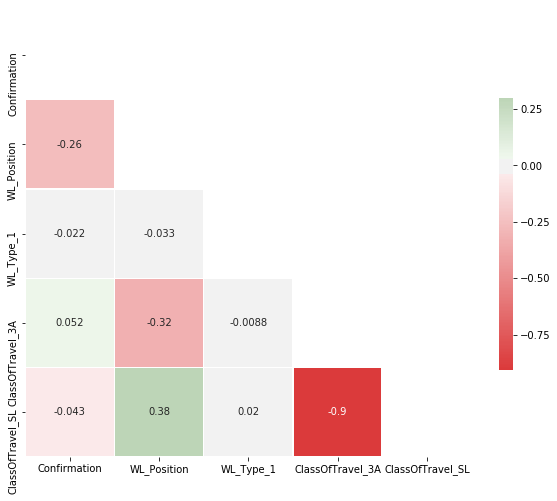

In [247]:
# Compute the correlation matrix

corr = ticket_dummy_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(12, 123, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [248]:
#Split Data

training_features = [ 'WL_Position', 'WL_Type_1', 'ClassOfTravel_3A',
       'ClassOfTravel_SL']

target = 'Confirmation'

train_x, test_x, train_y, test_y = train_test_split(ticket_dummy_df[training_features], 
                                                    ticket_dummy_df[target], train_size=0.8,random_state=400) 


C:\Users\anant\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Sensitivity =  0.21367521367521367
Specificity = 0.9545454545454546
Accuracy= 0.8201550387596899


Text(0.5,1,'DT - Confusion Matrix')

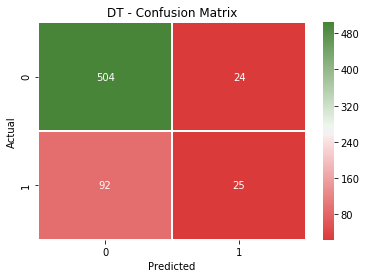

In [249]:
#Decision Trees
DT_model=DecisionTreeClassifier(
        criterion = "gini", random_state=0,max_depth=15,min_samples_leaf=10
                                    )
DT_model.fit(train_x,train_y)
DT_predictions = DT_model.predict(test_x)
DT_cm = confusion_matrix(test_y,DT_predictions)
tn, fp, fn, tp = DT_cm.ravel()
print("Sensitivity = ",tp/(tp+fn))
print("Specificity =", tn/(tn+fp))
print("Accuracy=",(tp+tn)/(tp+tn+fp+fn))
ax= plt.subplot()
cmap = sns.diverging_palette(12, 123, as_cmap=True)
sns.heatmap(DT_cm, annot=True,fmt = '1',cmap=cmap, linewidths=.5, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual') 
ax.set_title('DT - Confusion Matrix')

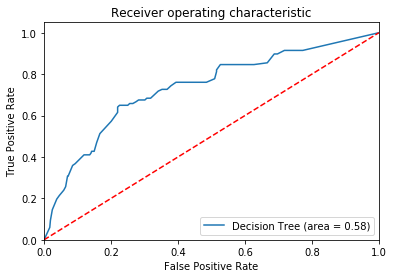

In [250]:
#ROC for decision tree model
dt_roc_auc = roc_auc_score(test_y,DT_predictions)
fpr, tpr, thresholds = roc_curve(test_y, DT_model.predict_proba(test_x)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('DT_ROC')
plt.show()

Sensitivity =  0.3162393162393162
Specificity = 0.8768939393939394
Accuracy= 0.7751937984496124


Text(0.5,1,'KNN - Confusion Matrix')

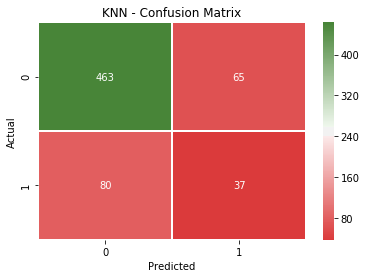

In [270]:
#KNN
KNN_model=neighbors.KNeighborsClassifier(n_neighbors=3,metric='minkowski')
KNN_model.fit(train_x,train_y)
KNN_predictions = KNN_model.predict(test_x)
KNN_cm = confusion_matrix(test_y,KNN_predictions)
tn, fp, fn, tp = KNN_cm.ravel()
print("Sensitivity = ",tp/(tp+fn))
print("Specificity =", tn/(tn+fp))
print("Accuracy=",(tp+tn)/(tp+tn+fp+fn))
ax= plt.subplot()
cmap = sns.diverging_palette(12, 123, as_cmap=True)
sns.heatmap(KNN_cm, annot=True,fmt='1',cmap=cmap, linewidths=.5, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual') 
ax.set_title('KNN - Confusion Matrix')

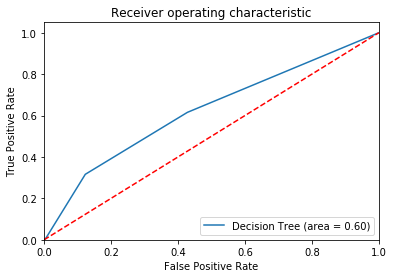

In [271]:
#ROC for KNN model
KNN_roc_auc = roc_auc_score(test_y,KNN_predictions)
fpr, tpr, thresholds = roc_curve(test_y, KNN_model.predict_proba(test_x)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % KNN_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN_ROC')
plt.show()